In [1]:

import json
import os
from pathlib import Path
from neo4j import GraphDatabase
import yaml

In [2]:
with open("config.yaml", "r") as stream:
    try:
        PARAM = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [3]:
driver = GraphDatabase.driver(PARAM["neo4j_url"], auth=(PARAM["neo4j_username"], PARAM["neo4j_password"]))

content = "smiles,id\n"

with driver.session() as session:
    result = session.run('MATCH (m:Medicine) RETURN m.name, m.SMILES')
    for r in result:
        #print (r)
        if r["m.SMILES"] != "":
            content += r["m.SMILES"] + "," + r["m.name"] + "\n"


In [4]:
with open("SMILES_structures.csv", "w") as file:
    file.write(content)

In [5]:
import pandas as pd

df = pd.read_csv('SMILES_structures.csv')
df.head()

,smiles,id
0,C1=CC=C(C=C1)C(=O)C2=CC=CC(=C2N)CC(=O)N,Nepafenac
1,C1=CC(=C(C=C1N)C(=O)O)O,Mesalazine
2,CN1CCCC1CC2=CNC3=C2C=C(C=C3)CCS(=O)(=O)C4=CC=C...,Eletriptan
3,CCC1=C(CN(C1=O)C(=O)NCCC2=CC=C(C=C2)S(=O)(=O)N...,Glimepiride
4,CC(=O)CC(C1=CC=CC=C1)C2=C(C3=CC=CC=C3OC2=O)O,Warfarin


In [6]:
from rdkit.Chem import Draw
from rdkit import Chem
from towhee.types.image_utils import from_pil

def to_images(data):
    imgs = []
    for smiles in data:
        mol = Chem.MolFromSmiles(smiles)
        img = from_pil(Draw.MolToImage(mol))
        imgs.append(img)
    return imgs



/home/dgg32/anaconda3/envs/milvus/lib/python3.11/site-packages/pydantic/_internal/_fields.py:151: UserWarning: Field "model_name" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [7]:
from pymilvus import connections, FieldSchema, CollectionSchema, DataType, Collection, utility

MILVUS_HOST = '127.0.0.1'
MILVUS_PORT = '19530'
connections.connect(host=MILVUS_HOST, port=MILVUS_PORT)

def create_milvus_collection(collection_name, dim):    
    if utility.has_collection(collection_name):
        utility.drop_collection(collection_name)
    
    fields = [
    FieldSchema(name='id', dtype=DataType.VARCHAR, descrition='ids', is_primary=True, auto_id=False, max_length=100),
    FieldSchema(name='smiles', dtype=DataType.VARCHAR, descrition='SMILES', max_length=1000),
    FieldSchema(name='embedding', dtype=DataType.BINARY_VECTOR, descrition='embedding vectors', dim=dim)
    ]
    schema = CollectionSchema(fields=fields, description='molecular similarity search')
    collection = Collection(name=collection_name, schema=schema)
    
    index_params = {"index_type": "BIN_FLAT", "params": {"nlist": 1024}, "metric_type": "JACCARD"}
    collection.create_index(field_name="embedding", index_params=index_params)
    
    return collection

collection = create_milvus_collection('molecular_search', 2048)

In [8]:
from towhee import ops, pipe

insert_pipe = (pipe.input('df')
                   .flat_map('df', ('smiles', 'id'), lambda df: df.values.tolist())
                   .map('smiles', 'fp', ops.molecular_fingerprinting.rdkit(algorithm='daylight'))
                   .map(('id', 'smiles', 'fp'), 'res', ops.ann_insert.milvus_client(host=MILVUS_HOST, 
                                                                           port=MILVUS_PORT,
                                                                           collection_name='molecular_search'))
                   .map('smiles', 'smiless', lambda x: print(x))
                   .output('res')
)

In [9]:
%%time
insert_pipe(df)

C1=CC=C(C=C1)C(=O)C2=CC=CC(=C2N)CC(=O)N
C1=CC(=C(C=C1N)C(=O)O)O
CN1CCCC1CC2=CNC3=C2C=C(C=C3)CCS(=O)(=O)C4=CC=CC=C4
CCC1=C(CN(C1=O)C(=O)NCCC2=CC=C(C=C2)S(=O)(=O)NC(=O)NC3CCC(CC3)C)C
CC(=O)CC(C1=CC=CC=C1)C2=C(C3=CC=CC=C3OC2=O)O
CC(C)OC(=O)C(C)(C)OC1=CC=C(C=C1)C(=O)C2=CC=C(C=C2)Cl
C1C(C(C(C(C1N)OC2C(C(C(C(O2)CN)O)O)N)OC3C(C(C(O3)CO)OC4C(C(C(C(O4)CN)O)O)N)O)O)N
CC(=O)OCC(CCN1C=NC2=CN=C(N=C21)N)COC(=O)C
CC1=C2COC(=O)C2=C(C(=C1OC)CC=C(C)CCC(=O)OCCN3CCOCC3)O
COC(=O)C(C1CCCCN1)C2=CC=CC=C2
CC1CC(=O)C=C(C12C(=O)C3=C(O2)C(=C(C=C3OC)OC)Cl)OC
CN1CCC(=C2C3=C(C(=O)CC4=CC=CC=C42)SC=C3)CC1
C1=CC=C(C=C1)C2=NC(C(=O)NC3=C2C=C(C=C3)Cl)O
[Cr]
CN(C)C(=O)C(CCN1CCC(CC1)(C2=CC=C(C=C2)Cl)O)(C3=CC=CC=C3)C4=CC=CC=C4
CC12CCC3C(C1CCC2C(=O)NC(C)(C)C)CCC4C3(C=CC(=O)N4)C
C1CCC(CC1)N2C(=NN=N2)CCCCOC3=CC4=C(C=C3)NC(=O)CC4
CN1C2=C(C(=O)N(C1=O)C)NC=N2
CC1CC2C3CCC(C3(CC(C2C4(C1=CC(=O)C=C4)C)O)C)(C(=O)CO)O
CC(C)OC(=O)OCOP(=O)(COC(C)CN1C=NC2=C(N=CN=C21)N)OCOC(=O)OC(C)C.C(=CC(=O)O)C(=O)O
CCOC(=O)C(CCC1=CC=CC=C1)NC2CCC3=CC=CC=C

In [10]:
collection.flush()
print('Total number of inserted data is {}.'.format(collection.num_entities))

Total number of inserted data is 459.


In [11]:
dummy_SMILES = "CCC1=C(CN(C1=O)C(=O)NCC2=CC=C(C=C2)S(=O)(=O)NC(=O)NC3CC(CC3)C)C"

In [12]:
from towhee import DataCollection

p1 = (pipe.input('df')
          .flat_map('df', ('smiles', 'id'), lambda df: df.values.tolist())
          .output('smiles', 'id')
     )
res = p1(df.head(3))
DataCollection(res).show()

smiles,id
C1=CC=C(C=C1)C(=O)C2=CC=CC(=C2N)CC(=O)N,Nepafenac
C1=CC(=C(C=C1N)C(=O)O)O,Mesalazine
CN1CCCC1CC2=CNC3=C2C=C(C=C3)CCS(=O)(=O)C4=CC=CC=C4,Eletriptan


In [22]:
search_pipe = (pipe.input('query_smiles')
                   .map('query_smiles', 'fp', ops.molecular_fingerprinting.rdkit(algorithm='daylight'))
                   .flat_map('fp', ('id', 'score', 'similar_smiles'), ops.ann_search.milvus_client(host=MILVUS_HOST, 
                                                                  port=MILVUS_PORT,
                                                                  collection_name='molecular_search',
                                                                  param={"metric_type": "JACCARD", "nprobe": 10},
                                                                  output_fields=['smiles']))
                   .output('id', 'score', 'similar_smiles')
)


In [23]:
res = search_pipe(dummy_SMILES)
DataCollection(res).show()

id,score,similar_smiles
Glimepiride,0.1681222766637802,CCC1=C(CN(C1=O)C(=O)NCCC2=CC=C(C=C2)S(=O)(=O)NC(=O)NC3CCC(CC3)C)C
Glibenclamide,0.49180328845977783,COC1=C(C=C(C=C1)Cl)C(=O)NCCC2=CC=C(C=C2)S(=O)(=O)NC(=O)NC3CCCCC3
Glipizide,0.5067178606987,CC1=CN=C(C=N1)C(=O)NCCC2=CC=C(C=C2)S(=O)(=O)NC(=O)NC3CCCCC3
Gliclazide,0.5812053084373474,CC1=CC=C(C=C1)S(=O)(=O)NC(=O)NN2CC3CCCC3C2
Ergotamine,0.5843439698219299,CC1(C(=O)N2C(C(=O)N3CCCC3C2(O1)O)CC4=CC=CC=C4)NC(=O)C5CN(C6CC7=CNC8=CC=CC(=C78)C6=C5)C


In [15]:
search_pipe_output_image = (pipe.input('query_smiles')
                   .map('query_smiles', 'fp', ops.molecular_fingerprinting.rdkit(algorithm='daylight'))
                   .flat_map('fp', ('id', 'score', 'similar_smiles'), ops.ann_search.milvus_client(host=MILVUS_HOST, 
                                                                  port=MILVUS_PORT,
                                                                  collection_name='molecular_search',
                                                                  limit=6,
                                                                  param={"metric_type": "JACCARD", "nprobe": 10},
                                                                  output_fields=['smiles']))
                   .window_all('query_smiles', 'query_smiles', lambda x: to_images(x[:1]))
                   .window_all('similar_smiles', 'similar_smiles_image', to_images)
                   .output('query_smiles', 'similar_smiles_image')
)


query_smiles,similar_smiles_image
,

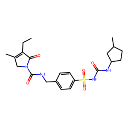
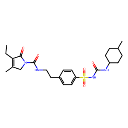
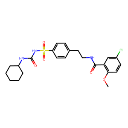
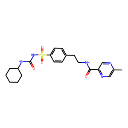
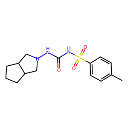
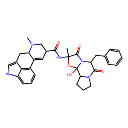
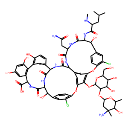

<Figure size 128x128 with 0 Axes>

<Figure size 128x128 with 0 Axes>

<Figure size 128x128 with 0 Axes>

<Figure size 128x128 with 0 Axes>

<Figure size 128x128 with 0 Axes>

<Figure size 128x128 with 0 Axes>

<Figure size 128x128 with 0 Axes>

In [16]:
res = search_pipe_output_image(dummy_SMILES)
DataCollection(res).show()